In [3]:
import json
import math
from collections import Counter

import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

import evaluation
import settings as cfg


### Predictions used from [GPT4_few_shot.csv](https://github.com/MohammadrezaPourreza/Few-shot-NL2SQL-with-prompting/blob/main/GPT4_results/GPT4_few_shot.csv)

In [4]:
df = pd.read_csv("resources\GPT4_few_shot.csv")
df.head()


,NLQ,PREDICTED SQL,GOLD SQL,DATABASE
0,How many singers do we have?,SELECT COUNT(*) FROM singer,SELECT count(*) FROM singer,concert_singer
1,What is the total number of singers?,SELECT COUNT(*) FROM singer,SELECT count(*) FROM singer,concert_singer
2,"Show name, country, age for all singers ordere...","SELECT name, country, age FROM singer ORDER BY...","SELECT name , country , age FROM singer ORDE...",concert_singer
3,"What are the names, countries, and ages for ev...","SELECT Name, Country, Age FROM singer ORDER BY...","SELECT name , country , age FROM singer ORDE...",concert_singer
4,"What is the average, minimum, and maximum age ...","SELECT AVG(age), MIN(age), MAX(age) FROM singe...","SELECT avg(age) , min(age) , max(age) FROM s...",concert_singer


### Evaluation using spiders [evaluation script](https://github.com/taoyds/spider/blob/master/evaluation.py)
All changes are explicitly marked with comments and **do not alter** the core evaluation logic — they only provide clearer labeling of whether a prediction is considered correct or incorrect.

In [ ]:
with open("resources/sql.gold", "w") as f:
    df["GOLD SQL"].apply(lambda x: str(x).replace("\t", " "))
    df[["GOLD SQL", "DATABASE"]].apply(lambda x: f.write(f"{x['GOLD SQL']}\t{x['DATABASE']}\n"), axis=1)

with open("resources/sql.pred", "w") as f:
    df["PREDICTED SQL"].apply(lambda x: str(x).replace("\t", " "))
    df["PREDICTED SQL"].apply(lambda x: f.write(f"{x}\n"))

kmaps = evaluation.build_foreign_key_map_from_json("spider_data/spider_data/tables.json")
etype = "all"
gold = "resources/sql.gold"
pred = "resources/sql.pred"
db_dir = "spider_data/spider_data/database"
matches = evaluation.evaluate(gold, pred, db_dir, etype, kmaps)

mapper: dict = {(p, g, db): value for p, g, db, value in matches}

df["MATCH"] = df.apply(lambda row: mapper.get((row["PREDICTED SQL"], row["GOLD SQL"], row["DATABASE"]), -1), axis=1).apply(pd.Series)


In [6]:
df.head()

,NLQ,PREDICTED SQL,GOLD SQL,DATABASE,MATCH
0,How many singers do we have?,SELECT COUNT(*) FROM singer,SELECT count(*) FROM singer,concert_singer,1
1,What is the total number of singers?,SELECT COUNT(*) FROM singer,SELECT count(*) FROM singer,concert_singer,1
2,"Show name, country, age for all singers ordere...","SELECT name, country, age FROM singer ORDER BY...","SELECT name , country , age FROM singer ORDE...",concert_singer,1
3,"What are the names, countries, and ages for ev...","SELECT Name, Country, Age FROM singer ORDER BY...","SELECT name , country , age FROM singer ORDE...",concert_singer,1
4,"What is the average, minimum, and maximum age ...","SELECT AVG(age), MIN(age), MAX(age) FROM singe...","SELECT avg(age) , min(age) , max(age) FROM s...",concert_singer,1


Two Predicted sql, gold sql and database as key in mapper could not be found, so I removed them.

In [7]:
df = df[df["MATCH"] != -1]
df.reset_index()

,index,NLQ,PREDICTED SQL,GOLD SQL,DATABASE,MATCH
0,0,How many singers do we have?,SELECT COUNT(*) FROM singer,SELECT count(*) FROM singer,concert_singer,1
1,1,What is the total number of singers?,SELECT COUNT(*) FROM singer,SELECT count(*) FROM singer,concert_singer,1
2,2,"Show name, country, age for all singers ordere...","SELECT name, country, age FROM singer ORDER BY...","SELECT name , country , age FROM singer ORDE...",concert_singer,1
3,3,"What are the names, countries, and ages for ev...","SELECT Name, Country, Age FROM singer ORDER BY...","SELECT name , country , age FROM singer ORDE...",concert_singer,1
4,4,"What is the average, minimum, and maximum age ...","SELECT AVG(age), MIN(age), MAX(age) FROM singe...","SELECT avg(age) , min(age) , max(age) FROM s...",concert_singer,1
...,...,...,...,...,...,...
1027,1029,What are the citizenships that are shared by s...,SELECT DISTINCT Citizenship FROM singer WHERE ...,SELECT Citizenship FROM singer WHERE Birth_Yea...,singer,0
1028,1030,How many available features are there in total?,SELECT COUNT(*) FROM Other_Available_Features,SELECT count(*) FROM Other_Available_Features,real_estate_properties,1
1029,1031,What is the feature type name of feature AirCon?,SELECT feature_type_name FROM Ref_Feature_Type...,SELECT T2.feature_type_name FROM Other_Availab...,real_estate_properties,0
1030,1032,Show the property type descriptions of propert...,SELECT property_type_description FROM Ref_Prop...,SELECT T2.property_type_description FROM Prope...,real_estate_properties,0


#### Ratios of labels

In [8]:
label_counts = df['MATCH'].value_counts()
label_counts

MATCH
1    560
0    472
Name: count, dtype: int64

#### Examples of predictions labeled with 0.

In [9]:
df[df['MATCH'] == 0].head(10)

,NLQ,PREDICTED SQL,GOLD SQL,DATABASE,MATCH
6,Show the name and the release year of the song...,"SELECT Name, Song_release_year FROM singer WHE...","SELECT song_name , song_release_year FROM sin...",concert_singer,0
7,What are the names and release years for all t...,"SELECT Name, Song_release_year FROM singer WHE...","SELECT song_name , song_release_year FROM sin...",concert_singer,0
16,What is the maximum capacity and the average o...,"SELECT max(capacity), avg(capacity) FROM stadium","select max(capacity), average from stadium",concert_singer,0
18,What is the name and capacity for the stadium ...,"SELECT Name, Capacity FROM stadium WHERE Avera...","SELECT name , capacity FROM stadium ORDER BY ...",concert_singer,0
19,What is the name and capacity for the stadium ...,"SELECT Name, Capacity FROM stadium WHERE Avera...","SELECT name , capacity FROM stadium ORDER BY ...",concert_singer,0
21,How many concerts occurred in 2014 or 2015?,SELECT count(*) FROM concert WHERE year IN (20...,SELECT count(*) FROM concert WHERE YEAR = 20...,concert_singer,0
22,Show the stadium name and the number of concer...,"SELECT T1.Name, COUNT(T2.concert_ID) FROM stad...","SELECT T2.name , count(*) FROM concert AS T1 ...",concert_singer,0
23,"For each stadium, how many concerts play there?","SELECT COUNT(concert_ID) , Stadium_ID FROM co...","SELECT T2.name , count(*) FROM concert AS T1 ...",concert_singer,0
24,Show the stadium name and capacity with most n...,"SELECT T1.Name, T1.Capacity FROM stadium AS T1...","SELECT T2.name , T2.capacity FROM concert AS ...",concert_singer,0
30,Show countries where a singer above age 40 and...,SELECT DISTINCT T1.Country FROM singer AS T1 J...,SELECT country FROM singer WHERE age > 40 IN...,concert_singer,0


In [10]:
df.to_csv("resources/labeled_sql_data.csv", index=False)

## Extracting linguistic Features
For Frequency the following data was used: <br>
For word frequency: https://github.com/hermitdave/FrequencyWords/blob/master/content/2018/en/en_50k.txt <br>
For rare words: https://github.com/hermitdave/FrequencyWords/blob/master/content/2018/en/en_full.txt

In [11]:
with open("resources/en_50k.txt", "r", encoding="utf-8") as f:
    frequent_words = set(map(lambda x: x.split(" ")[0], f.readlines()))

with open("resources/en_full.txt", "r", encoding="utf-8") as f:
    rare_words = set([line.split(" ")[0] for line in f.readlines() if int(line.split(" ")[1]) < cfg.RARE_WORD_THRESHOLD])

nlp = spacy.load("en_core_web_sm")

def extract_features(question):
    doc = nlp(question)

    # general
    features = {
        "num_tokens": len(doc),
        "is_wh_question": any(token.text.lower() in ["what", "where", "who", "how", "why"] for token in doc),
        "has_negation": any(token.text.lower() in ["not", "no"] for token in doc),
        "num_entities": len(doc.ents),
        "num_unique_dependencies": len(set(token.dep_ for token in doc)),
        "max_head_distance": max([token.head.i for token in doc] + [0]),
        "max_subtree_size": max([len(list(token.subtree)) for token in doc]),
    }

    # POS-Tagging
    pos_counts = Counter(token.pos_ for token in doc)
    features.update({
        "num_nouns": pos_counts.get("NOUN", 0),
        "num_verbs": pos_counts.get("VERB", 0),
        "num_adjectives": pos_counts.get("ADJ", 0),
        "num_adverbs": pos_counts.get("ADV", 0),
    })

    # count entities for type
    entity_counts = Counter(ent.label_ for ent in doc.ents)
    features.update({
        "num_persons": entity_counts.get("PERSON", 0),
        "num_orgs": entity_counts.get("ORG", 0),
        "num_locations": entity_counts.get("GPE", 0),
    })

    # frequent words
    # Log frequency of words int question that are frequent words
    try:
        features["frequent_tokens"] = -math.log(sum([1 for token in doc if str(token).lower() in frequent_words]) / len(doc))
    except ValueError:
        features["frequent_tokens"] = 0

    # rare words
    try:
        features["rare_tokens"] = -math.log(sum([1 for token in doc if str(token).lower() in rare_words]) / len(doc))
    except ValueError:
        features["rare_tokens"] = 0

    return features


## Training on these models

In [12]:
models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
}

## Without PCA

In [13]:
X = df.apply(lambda row: extract_features(row['NLQ']), axis=1).apply(pd.Series)

X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['MATCH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # uncomment for a more detailed insight
    #print(f"Evaluating {name}...")

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    mean_cv_score = cv_scores.mean()

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = {
        "mean_cv_score": mean_cv_score,
        "test_accuracy": acc,
        "classification_report": classification_report(y_test, y_pred)
    }
    
    # uncomment for a more detailed insight
    #print(f"{name}: CV Mean Accuracy = {mean_cv_score:.4f}, Test Accuracy = {acc:.4f}")

best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name} with Test Accuracy {results[best_model_name]['test_accuracy']:.4f}")
print(f"\nClassification Report for {best_model_name}:\n{results[best_model_name]['classification_report']}")


Best Model: Logistic Regression with Test Accuracy 0.6135

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.62      0.44      0.51        96
           1       0.61      0.77      0.68       111

    accuracy                           0.61       207
   macro avg       0.61      0.60      0.60       207
weighted avg       0.61      0.61      0.60       207



The model correctly predicted ~61% of the test cases. <br> 
It was slightly better at identifying class '1' (77% recall) than class '0' (44% recall), meaning it missed more '0'.

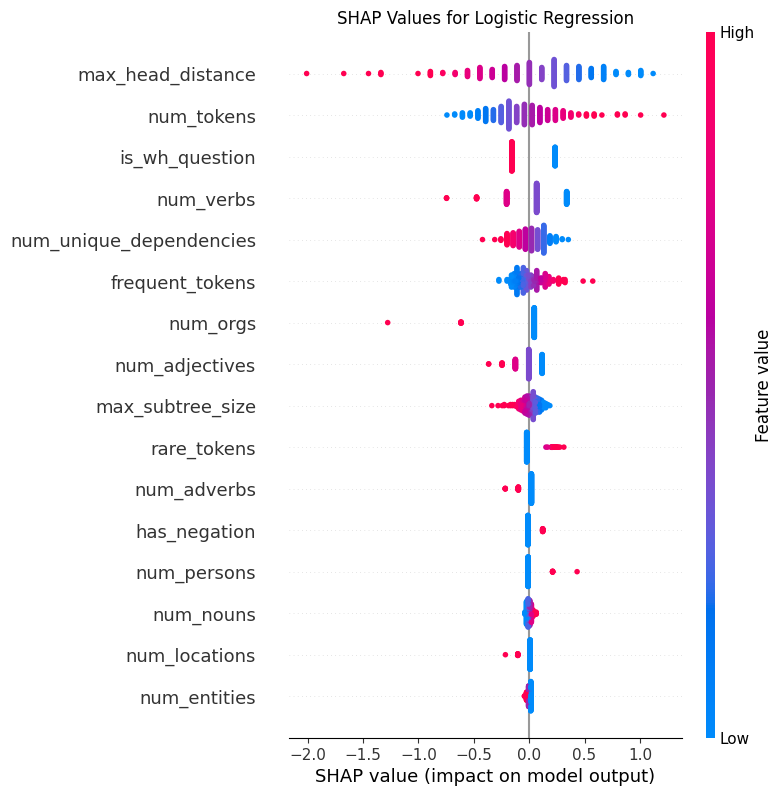

In [14]:
explainer = shap.LinearExplainer(best_model, X_train_scaled, feature_names=X.columns)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title("SHAP Values for Logistic Regression")
plt.show()

Complex sentences tend to slightly favors predicitons towards Class 1. <br>
An increasing number of tokens slightly favor predicitons towards Class 0.

## Try Classifier on test.json

In [15]:
with open('spider_data/spider_data/test.json', 'r') as f:
    test_data = json.load(f)

test_df = pd.DataFrame(test_data)
test_df

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,soccer_3,SELECT count(*) FROM club,"[SELECT, count, (, *, ), FROM, club]","[select, count, (, *, ), from, club]",How many clubs are there?,"[How, many, clubs, are, there, ?]","{'from': {'table_units': [['table_unit', 0]], ..."
1,soccer_3,SELECT count(*) FROM club,"[SELECT, count, (, *, ), FROM, club]","[select, count, (, *, ), from, club]",Count the number of clubs.,"[Count, the, number, of, clubs, .]","{'from': {'table_units': [['table_unit', 0]], ..."
2,soccer_3,SELECT Name FROM club ORDER BY Name ASC,"[SELECT, Name, FROM, club, ORDER, BY, Name, ASC]","[select, name, from, club, order, by, name, asc]",List the name of clubs in ascending alphabetic...,"[List, the, name, of, clubs, in, ascending, al...","{'from': {'table_units': [['table_unit', 0]], ..."
3,soccer_3,SELECT Name FROM club ORDER BY Name ASC,"[SELECT, Name, FROM, club, ORDER, BY, Name, ASC]","[select, name, from, club, order, by, name, asc]","What are the names of clubs, ordered alphabeti...","[What, are, the, names, of, clubs, ,, ordered,...","{'from': {'table_units': [['table_unit', 0]], ..."
4,soccer_3,"SELECT Manager , Captain FROM club","[SELECT, Manager, ,, Captain, FROM, club]","[select, manager, ,, captain, from, club]",What are the managers and captains of clubs?,"[What, are, the, managers, and, captains, of, ...","{'from': {'table_units': [['table_unit', 0]], ..."
...,...,...,...,...,...,...,...
2142,advertising_agencies,"SELECT staff_id , staff_details FROM staff WH...","[SELECT, staff_id, ,, staff_details, FROM, sta...","[select, staff_id, ,, staff_details, from, sta...",Return the ids and details of staff who have a...,"[Return, the, ids, and, details, of, staff, wh...","{'from': {'table_units': [['table_unit', 1]], ..."
2143,advertising_agencies,"SELECT T1.client_id , T1.sic_code , T1.agenc...","[SELECT, T1.client_id, ,, T1.sic_code, ,, T1.a...","[select, t1, ., client_id, ,, t1, ., sic_code,...","What are the id, sic code and agency id of the...","[What, are, the, id, ,, sic, code, and, agency...","{'from': {'table_units': [['table_unit', 2], [..."
2144,advertising_agencies,"SELECT T1.client_id , T1.sic_code , T1.agenc...","[SELECT, T1.client_id, ,, T1.sic_code, ,, T1.a...","[select, t1, ., client_id, ,, t1, ., sic_code,...","Return the ids, sic codes, and agency ids of c...","[Return, the, ids, ,, sic, codes, ,, and, agen...","{'from': {'table_units': [['table_unit', 2], [..."
2145,advertising_agencies,"SELECT T1.start_date_time , T1.end_date_time ...","[SELECT, T1.start_date_time, ,, T1.end_date_ti...","[select, t1, ., start_date_time, ,, t1, ., end...","List the start time, end time of each meeting,...","[List, the, start, time, ,, end, time, of, eac...","{'from': {'table_units': [['table_unit', 4], [..."


In [16]:
test_features_extracted = test_df['question'].apply(lambda q: extract_features(q)).apply(pd.Series)
test_features_extracted

,num_tokens,is_wh_question,has_negation,num_entities,num_unique_dependencies,max_head_distance,max_subtree_size,num_nouns,num_verbs,num_adjectives,num_adverbs,num_persons,num_orgs,num_locations,frequent_tokens,rare_tokens
0,6,True,False,0,5,3,6,1,0,1,1,0,0,0,0.182322,0.0
1,6,False,False,0,6,3,6,2,1,0,0,0,0,0,0.182322,0.0
2,10,False,False,0,8,8,10,3,2,1,0,0,0,0,0.105361,0.0
3,10,True,False,0,9,7,10,2,1,0,1,0,0,0,0.223144,0.0
4,9,True,False,0,9,6,9,3,0,0,0,0,0,0,0.117783,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,23,True,False,1,15,21,23,7,3,1,0,0,0,0,0.090972,0.0
2143,25,True,False,1,15,23,25,6,2,0,0,0,0,0,0.127833,0.0
2144,22,True,False,1,13,20,22,8,3,0,0,0,0,0,0.200671,0.0
2145,20,False,False,0,11,18,20,7,3,1,0,0,0,0,0.162519,0.0


In [17]:
X_test_new_scaled = scaler.transform(test_features_extracted)
y_pred_new = best_model.predict(X_test_new_scaled)
y_true = np.ones(len(y_pred_new))
accuracy = accuracy_score(y_true, y_pred_new)

print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_true, y_pred_new))

Test Accuracy: 0.6530
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.65      0.79      2147

    accuracy                           0.65      2147
   macro avg       0.50      0.33      0.40      2147
weighted avg       1.00      0.65      0.79      2147



C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: Unde

Note: the test.json data only contains class 1 predictions. <br>
The model correctly identified 65% of the true "1"s.

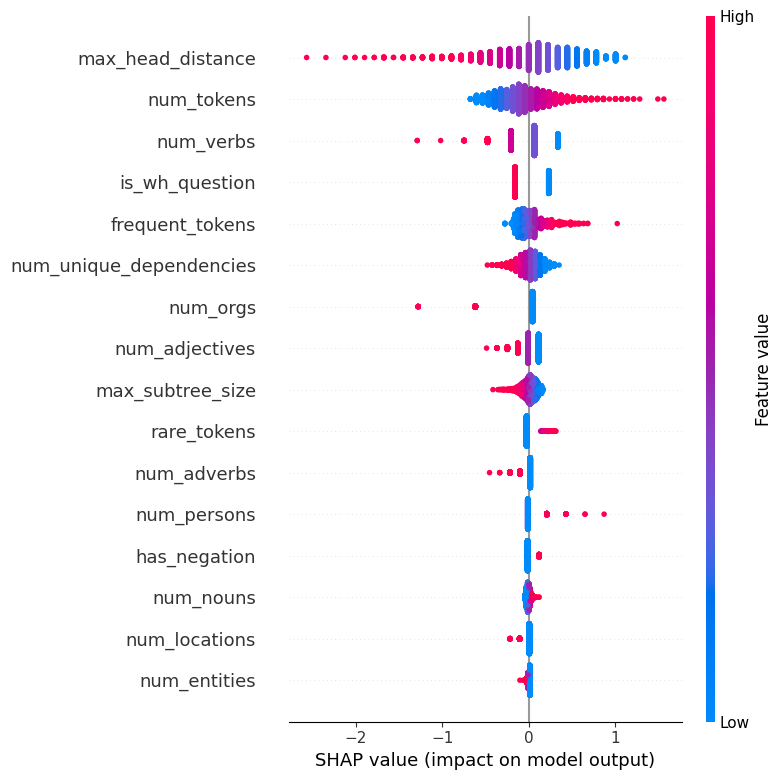

In [18]:
explainer = shap.Explainer(best_model, X_train_scaled) 
shap_values = explainer(X_test_new_scaled)

shap.summary_plot(shap_values, X_test_new_scaled, feature_names=test_features_extracted.columns, show=False)

Complex sentences, frequent tokens and subtrees slightly favor predicitons towards Class 1. <br>
For the most sentences the number of tokens and unique dependencies slightly favor predicitons towards Class 0.

## With PCA

In [ ]:
X_pca = df['NLQ'].apply(lambda q: extract_features(q)).apply(pd.Series)
y_pca = df['MATCH']

X_pca = X_pca.apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardization/Centering PCA
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X_pca)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_scaled_pca, y_pca, test_size=0.2, random_state=42
)

results_pca = {}

for n_components in range(1, X_train_pca.shape[1] + 1):
    pca = PCA(n_components=n_components)
    X_train_pca_transformed = pca.fit_transform(X_train_pca)
    X_test_pca_transformed = pca.transform(X_test_pca)

    for name, model in models.items():
        cv_scores_pca = cross_val_score(model, X_train_pca_transformed, y_train_pca, cv=5, scoring='accuracy')
        mean_cv_score_pca = cv_scores_pca.mean()

        model.fit(X_train_pca_transformed, y_train_pca)
        y_pred_pca = model.predict(X_test_pca_transformed)
        acc_pca = accuracy_score(y_test_pca, y_pred_pca)

        results_pca[(name, n_components)] = {
            "mean_cv_score": mean_cv_score_pca,
            "test_accuracy": acc_pca,
            "classification_report": classification_report(y_test_pca, y_pred_pca)
        }
        # uncomment for more detailed insight
        #print(f"Model: {name}, PCA Components: {n_components}, CV Mean Accuracy = {mean_cv_score_pca:.4f}, Test Accuracy = {acc_pca:.4f}")

best_result_key_pca = max(results_pca, key=lambda x: results_pca[x]['test_accuracy'])
best_model_name_pca, best_n_components_pca = best_result_key_pca

best_model_pca = models[best_model_name_pca]
best_pca_transformer = PCA(n_components=best_n_components_pca)

X_train_pca_best = best_pca_transformer.fit_transform(X_train_pca)
best_model_pca.fit(X_train_pca_best, y_train_pca)

print(f"\nBest PCA Model: {best_model_name_pca} with {best_n_components_pca} PCA Components, Test Accuracy = {results_pca[best_result_key_pca]['test_accuracy']:.4f}")
print(f"\nPCA Classification Report:\n{results_pca[best_result_key_pca]['classification_report']}")


Best PCA Model: Random Forest with 12 PCA Components, Test Accuracy = 0.6184

PCA Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        96
           1       0.64      0.68      0.66       111

    accuracy                           0.62       207
   macro avg       0.62      0.61      0.61       207
weighted avg       0.62      0.62      0.62       207



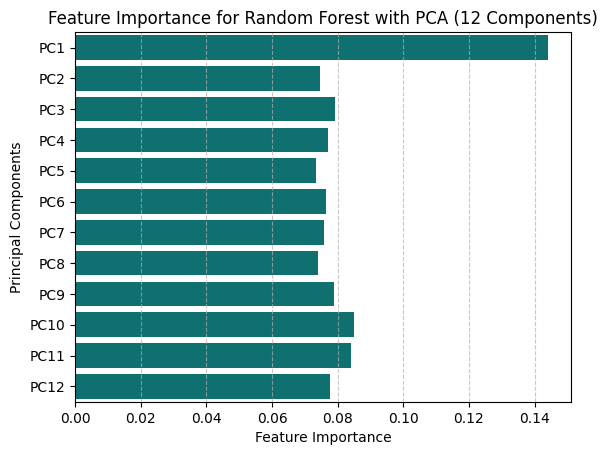

In [20]:
feature_importance_rf = best_model_pca.feature_importances_

sns.barplot(x=feature_importance_rf, y=[f'PC{i+1}' for i in range(best_n_components_pca)], color="teal")
plt.title(f'Feature Importance for Random Forest with PCA ({best_n_components_pca} Components)')
plt.xlabel("Feature Importance")
plt.ylabel("Principal Components")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

Calculation of the percentage contribution of each feature to the principal components and selection of the top features that contribute up to 80% of the variance for each principal component.

In [21]:
loadings = best_pca_transformer.components_

absolute_contributions = np.abs(loadings)
percentage_contributions = absolute_contributions / absolute_contributions.sum(axis=1, keepdims=True) * 100

contrib_df = pd.DataFrame(
    percentage_contributions,
    columns=X.columns,
    index=[f"PC{i+1}" for i in range(best_n_components_pca)]
)

def select_top_features(row, target=80):
    sorted_row = row.sort_values(ascending=False)
    cumsum = sorted_row.cumsum()
    top_features = sorted_row[cumsum <= target]
    return top_features

contrib_df
contributions = contrib_df.apply(select_top_features, axis=1)
contributions.fillna('-') # '-' for NaN (values under threshold) for easier reading

,frequent_tokens,has_negation,is_wh_question,max_head_distance,max_subtree_size,num_adjectives,num_adverbs,num_entities,num_locations,num_nouns,num_orgs,num_persons,num_tokens,num_unique_dependencies,num_verbs,rare_tokens
PC1,-,-,-,15.770641,14.775331,-,-,-,-,12.379627,-,-,15.768233,14.24247,-,-
PC2,18.110366,-,-,-,-,5.067489,-,15.01765,-,-,17.504672,7.213288,-,-,-,16.104956
PC3,-,7.943389,24.908516,-,-,16.756039,-,7.954594,-,-,-,-,-,-,20.614408,-
PC4,7.0874,14.945492,-,-,-,9.403894,8.189118,-,14.151808,-,8.206777,13.99454,-,-,-,-
PC5,-,-,-,-,-,-,-,-,33.623427,-,7.815701,33.107501,-,-,-,-
PC6,-,13.936297,-,-,-,-,24.374579,10.226239,9.236105,-,9.122134,11.362247,-,-,-,-
PC7,-,20.61202,11.275495,-,-,-,21.860981,-,5.836815,7.596927,-,7.813215,-,-,-,-
PC8,10.600952,-,-,-,-,15.638522,-,7.662641,7.542865,-,17.081535,-,-,-,-,14.676991
PC9,-,7.854698,6.04987,-,-,17.000352,-,11.154474,-,12.260769,-,-,-,-,8.398311,12.034628
PC10,-,10.047915,15.674226,-,-,7.421861,7.740951,-,-,10.702491,-,-,-,5.583173,19.804721,-


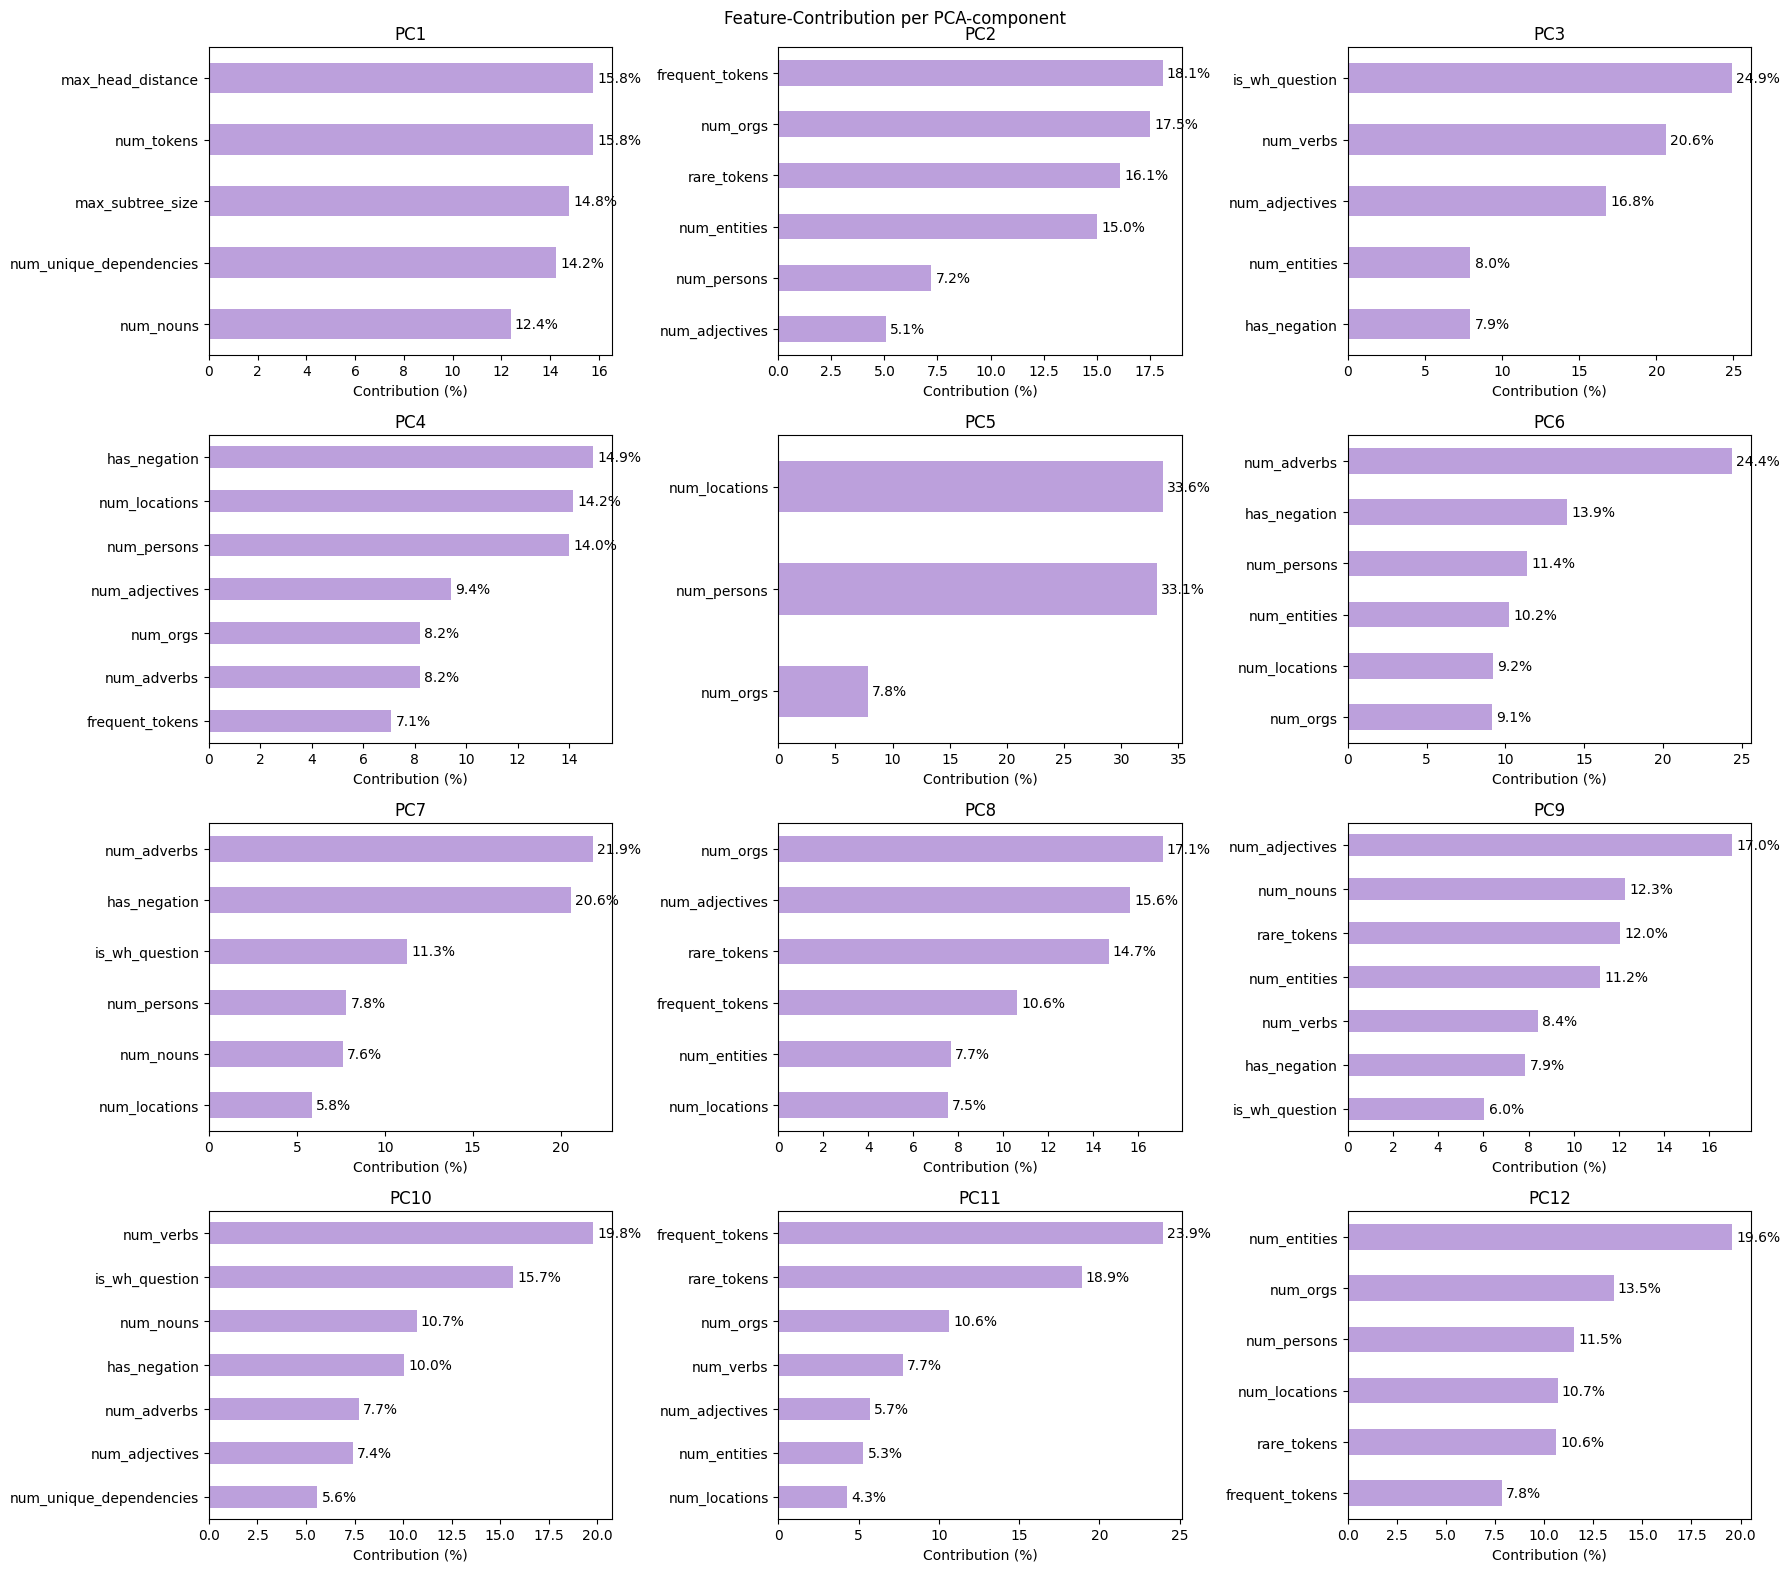

In [26]:
n_cols = 3
n_rows = int(np.ceil(best_n_components_pca / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for i, pc in enumerate(contributions.index):
    pc_data = contributions.loc[pc].dropna()
    if len(pc_data) > 0:
        ax = axes[i]
        pc_data.sort_values().plot(kind='barh', ax=ax, color='#bca0dc')
        ax.set_title(pc)
        ax.set_xlabel('Contribution (%)')
        
        for p in ax.patches:
            width = p.get_width()
            ax.annotate(f'{width:.1f}%',
                        (width, p.get_y() + p.get_height()/2),
                        ha='left', va='center',
                        xytext=(3, 0),
                        textcoords='offset points')

plt.suptitle(f'Feature-Contribution per PCA-component')
plt.tight_layout()
plt.show()

The Components seem to be very diversly arranged . <br>
However, since the PC1 seems to have the most significant influence, the most important features seem to be:
- max_head_distance (15.8%)
- num_tokens (15.8%)
- max_subtree_size (14.8%)
- num_unique_dependencies (14.2%)
- num_nouns (12.4%).

## Try Classifier on test.json

In [ ]:
X_test_new_scaled = scaler_pca.transform(test_features_extracted)
X_test_new_pca = best_pca_transformer.transform(X_test_new_scaled)

y_pred_new = best_model_pca.predict(X_test_new_pca)

y_true = np.ones(len(y_pred_new))

accuracy = accuracy_score(y_true, y_pred_new)
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(y_true, y_pred_new))


Test Accuracy: 0.5366
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.54      0.70      2147

    accuracy                           0.54      2147
   macro avg       0.50      0.27      0.35      2147
weighted avg       1.00      0.54      0.70      2147



C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: Unde

Note: the test.json data only contains class 1 predictions. <br>
The model correctly identified approximately 54% of the true "1"s.